# Deep LPBM: Frobenius norm error Deep LPBM vs SBM initialisation

**Introduction to Probabilistic Graphical Models and Deep Generative Models (MVA 2025-2026)**  

**Student:** Karina Musina
**Email:** karina.musina@student-cs.fr
**Student:** Yannaël Bossard
**Email:** yannael.bossard@ens-paris-saclay.fr  
**Report Deadline:** 17 / 12 / 2025
**Poster Deadline:** 18 / 12 / 2025


### Objective:
In this notebook, we compare the Frobenius norm error from the true connectivity matrix $\Pi^\ast$ to $\hat{\Pi}$ (estimated by Deep LPBM), and $\Pi^0$ (SBM initialisation)



Studied paper: https://doi.org/10.1007/s11222-025-10679-7
Further explaination: https://hal.science/hal-04910241v1/document



Warning: There may be some typo in the notebook, where we call $\Pi^0$ the Pi_kmean, and vice-versa. Because the decoder is frozen during the pretraining, it's actually the same matrix.


### Libraries

In [1]:
from logging import debug
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import matplotlib.patches
import warnings
from sklearn.manifold import TSNE
import networkx as nx
import pandas as pd

import os
import sys
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

try:
  from torch_geometric.nn import GCNConv
  from torch_geometric.utils import dense_to_sparse
except:
  !pip install torch_geometric
  from torch_geometric.nn import GCNConv
  from torch_geometric.utils import dense_to_sparse

try:
  import umap
except:
  !pip install umap-learn
  import umap

from scipy.optimize import linear_sum_assignment
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

debug_mode = False


def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    os.environ['PYTHONHASHSEED'] = str(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(31)

Using device: cuda


## I- Benchmarks

Implementation and visualization of Assortative/Disassortative/Hub graphs

In [2]:
def create_connect_matrix(graph_struct="disassortative", n_clusters=5, Beta=0.3, Epsi = 0.05, undirected=True):
  '''
  This function generates the connectivity matrix of a graph with n_clusters clusters as described in the paper Sec.5

  Parameters-->
  n_clusters: Number of clusters in the graph.
  graph_struct: Graph structure you want to generate between "disassortative"/"assortative"/"hub"
  Beta : Parameter for the probability/strength of connectivity
  Epsi : Parameter for the probability/strength of unconnectivity

  Returns-->
  connectivity_matrix : (np.array) Connectivity matrix $\Pi$ of the graph.
  '''

  # Create connectivity matrix
  connectivity_matrix = np.zeros((n_clusters, n_clusters))

  if graph_struct=="assortative":
    ### COMMUNITIES-like graph
    for i in range(n_clusters):
      for j in range(n_clusters):
        if i == j:
          connectivity_matrix[i, j] = np.clip(np.random.normal(Beta, 0.02), 0, 3*Beta)
        else:
          connectivity_matrix[i, j] = np.clip(np.random.normal(Epsi, 0.01), 0, 3*Epsi)

  elif graph_struct=="disassortative":
    ### DISASSORTATIVE-like graph
    for i in range(n_clusters):
      for j in range(n_clusters):
        if i == j:
          connectivity_matrix[i, j] = np.clip(np.random.normal(Epsi, 0.01), 0, 3*Epsi)
        else:
          connectivity_matrix[i, j] = np.clip(np.random.normal(Beta, 0.02), 0, 3*Beta)

  elif graph_struct=="hub":
    ### HUB-like graph
    for i in range(n_clusters):
      for j in range(n_clusters):

        if i == j:
          connectivity_matrix[i, j] = np.clip(np.random.normal(Beta, 0.01), 0, 3*Beta)
        else:
          connectivity_matrix[i, j] = np.clip(np.random.normal(Epsi, 0.02), 0, 3*Epsi)
    fully_connected_cluster = np.random.choice(n_clusters, size=1, replace=False)
    connectivity_matrix[fully_connected_cluster, :] = np.clip(np.random.normal(Beta, 0.02,size=(1, n_clusters)), 0, 3*Beta)
    connectivity_matrix[:,fully_connected_cluster] = np.clip(np.random.normal(Beta, 0.02,size=(n_clusters,1)), 0, 3*Beta)

  else:
    raise ValueError("Invalid graph structure! You have to select among 'assortative'/'disassortative'/'hub' ...")


  #raise ValueError(" Watch out, check out the course, the connectivity matrix should be symmetric because the adjacency matrix is ")
  if undirected:
    connectivity_matrix = 0.5*(connectivity_matrix + connectivity_matrix.T) # ensure it's symmetric
  else:
    pass # directivity will be induced only by the additional random noise

  return connectivity_matrix


def create_simple_graph(n_nodes, n_clusters,graph_struct="disassortative", undirected=True, Beta=0.3, Epsi=0.05, Zeta=0.99, shuffle=False, plot=False):
  '''
  This function creates a simple graph structure with n_nodes nodes and n_clusters clusters as described in the paper Sec.5

  Parameters-->
  n_nodes: Number of nodes in the graph.
  n_clusters: Number of clusters in the graph.
  graph_struct: Graph structure. The default is "disassortative".
  undirected: Whether the graph is undirected or not. The default is True as in the paper
  n_clusters: Number of clusters in the graph.
  graph_struct: Graph structure you want to generate between "disassortative"/"assortative"/"hub"
  Beta : Parameter for the probability/strength of connectivity
  Epsi : Parameter for the probability/strength of unconnectivity
  Zeta: Add some noise/uniformity to the latent connectivity per nodes.
  shuffle: Whether to shuffle the adjacency matrix or not.
  plot: (boolean) Whether to plot the graph or not

  Returns-->
  Adja_matrix: (np.array) Adjacency matrix of the graph. (size=(n_nodes,n_nodes))
  connectivity_matrix : (np.array) Connectivity matrix $\Pi$ of the graph. (size=(n_clusters,n_clusters))
  eta_star:  (np.array) latent connectivity per nodes (size=(n_nodes,n_clusters))
  '''

  # Create connectivity metrix
  Pi_connectivity_matrix = create_connect_matrix(graph_struct=graph_struct, n_clusters=n_clusters, Beta=Beta, Epsi = Epsi,undirected=undirected)

  # η ∈ R^{N×Q} with rows on the simplex.
  eta_onehot = np.zeros((n_nodes,n_clusters))
  # Lets assume a equidistributed population among clusters
  nodes_label = np.repeat(np.arange(n_clusters), n_nodes // n_clusters)
  nodes_label = np.concatenate([nodes_label, nodes_label[-1]*np.ones(n_nodes-len(nodes_label))]).astype(np.int32)

  for i,label in enumerate(nodes_label):
    eta_onehot[i,label] = 1


  eta_unif = np.full((n_nodes, n_clusters), (1.0 - Zeta) / n_clusters, dtype=float)
  eta_star = Zeta*eta_onehot + eta_unif

  P = eta_star @ Pi_connectivity_matrix @ eta_star.T # probability matrix of connectivity

  # Create the adjacency matrix of the graph
  Adja_matrix = np.zeros((n_nodes, n_nodes))

  if undirected: # Adja_matrix is symmetric
    for i in range(n_nodes):
      for j in range(i+1, n_nodes):
        Aij = np.random.binomial(1, P[i, j])
        Adja_matrix[i, j] = Aij
        Adja_matrix[j, i] = Aij  # symmetry

  if not undirected: # Adja_matrix is not necessarily symmetric
    for i in range(n_nodes):
      for j in range(n_nodes):
        if i != j:
          Aij = np.random.binomial(1, P[i, j])
          Adja_matrix[i, j] = Aij


  # Compute density:
  density = np.sum(Adja_matrix) / (n_nodes * (n_nodes - 1))
  #print("density = ", density)

  if shuffle:
    perm_indices = np.random.permutation(n_nodes)

    # suffle Rows & Columns to preserve graph topology
    Adja_matrix = Adja_matrix[perm_indices, :]
    Adja_matrix = Adja_matrix[:, perm_indices]

    # Apply the SAME permutation to the ground truth labels
    eta_star = eta_star[perm_indices, :]
    nodes_label = nodes_label[perm_indices]

  if plot:

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Connectivity matrix
    im0 = axes[0].imshow(Pi_connectivity_matrix, interpolation='nearest')
    axes[0].set_title("Connectivity matrix Π")
    axes[0].set_xlabel("cluster")
    axes[0].set_ylabel("cluster")
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    # Adjacency matrix
    im1 = axes[1].imshow(Adja_matrix, interpolation='nearest')
    axes[1].set_title("Adjacency matrix A")
    axes[1].set_xlabel("node")
    axes[1].set_ylabel("node")
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    fig.suptitle(f" {graph_struct} graph structure Instance, density={density:.3f}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


  return Adja_matrix, Pi_connectivity_matrix, eta_star, nodes_label




<>:12: SyntaxWarning: invalid escape sequence '\P'
<>:81: SyntaxWarning: invalid escape sequence '\P'
<>:12: SyntaxWarning: invalid escape sequence '\P'
<>:81: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipython-input-2074829072.py:12: SyntaxWarning: invalid escape sequence '\P'
  connectivity_matrix : (np.array) Connectivity matrix $\Pi$ of the graph.
/tmp/ipython-input-2074829072.py:81: SyntaxWarning: invalid escape sequence '\P'
  connectivity_matrix : (np.array) Connectivity matrix $\Pi$ of the graph. (size=(n_clusters,n_clusters))


# Neural Network Benchmark

Here, we want to create a connectivity matrix that reproduce a biologically plausible neural network.

Hypothesis:


*   4 clusters
*   Exci -> Inhi etc.



In [3]:
def create_BNN_connect_matrix(K_strength=1,Epsi = 0.05):
  '''
  This function generates the connectivity matrix of a graph with ....

  Input:
  K_strength = 1 # modulate the probability of connectivity in within/in between clusters

  exci0 <=> perception input
  exci1 <=> pre-processig and alimenting compartment
  exci2 <=> specialized compartment

  inhi1 <=> regularization of activity in the network
  exci3 <=> controling head
  '''

  n_populations = 5

  # Create connectivity matrix
  connectivity_matrix = np.ones((n_populations, n_populations))*Epsi*K_strength

  # Exci0: perception input, connect only, but strongly, to the Exci1 population, cannot be regulated
  connectivity_matrix[0, 1] = np.clip(np.random.normal(K_strength*0.9, 0.02), 1e-2, 1-1e-2)

  # Exci1: pre-processig and alimenting compartment, connect strongly to Exci2 (transmission of pre-processed input) + slightly to all others for awarness
  connectivity_matrix[1, [1,3,4]] = np.clip(np.random.normal(K_strength*0.42, 0.02), 1e-2, 1-1e-2)
  connectivity_matrix[1, 2] = np.clip(np.random.normal(K_strength*0.7, 0.02), 1e-2, 1-1e-2)

  # Exci2: Specialized processing, connect strongly to itself for computation, and then send information to control head (Exci3)
  connectivity_matrix[2, 4] = np.clip(np.random.normal(K_strength*0.85, 0.02), 1e-2, 1-1e-2)
  connectivity_matrix[2, 2] = np.clip(np.random.normal(K_strength*0.70, 0.02), 1e-2, 1-1e-2)

  # Exci3: Control head: connect to only to Inhi population, for regularization of the global network activity + decision making
  connectivity_matrix[4, 3] = np.clip(np.random.normal(K_strength*0.75, 0.02), 1e-2, 1-1e-2)

  # Inhi1: Regularizator: connect to all processing/computing compartment for regularization of activity
  connectivity_matrix[3, [1,2]] = np.clip(np.random.normal(K_strength*0.5, 0.02), 1e-2, 1-1e-2)

  return connectivity_matrix, n_populations


def create_synthetic_BNN(n_neurons=1000, K_strength=1, Epsi=0.05, Zeta=0.99, shuffle=True, plot=False):
  '''
  This function creates ...
  '''


  n_exci_neurons = int(0.8*n_neurons)
  n_inhi_neurons = int(n_neurons - n_exci_neurons) # E/I rate is empirically assumed to be roughly 80% excitatory-20% inhibitory in biological neural networks
  n_exci0_2exci1 = int(0.15*n_exci_neurons)
  n_exci1_2all = int(0.4*n_exci_neurons)
  n_exci2_2exci3 = int(0.2*n_exci_neurons)
  n_exci3_2inhi1 = int(0.25*n_exci_neurons)
  n_inhi_2all = n_inhi_neurons
  n_neurons_populations = [n_exci0_2exci1,n_exci1_2all,n_exci2_2exci3,n_exci3_2inhi1,n_inhi_2all]


  # Create connectivity metrix
  Pi_connectivity_matrix, n_populations = create_BNN_connect_matrix(K_strength=K_strength,Epsi=Epsi)
  n_nodes = n_neurons
  n_clusters = n_populations

  # η ∈ R^{N×Q} with rows on the simplex.
  eta_onehot = np.zeros((n_nodes,n_clusters))

  # Lets not assume a equidistributed population among clusters
  nodes_label = np.empty(0, dtype=np.int32)
  for idx_popul, n_neuron_popul in enumerate(n_neurons_populations):
    nodes_label_tmp = idx_popul*np.ones(n_neuron_popul)
    nodes_label = np.concatenate([nodes_label,nodes_label_tmp]).astype(np.int32)


  for i,label in enumerate(nodes_label):
    eta_onehot[i,label] = 1

  eta_unif = np.full((n_nodes, n_clusters), (1.0 - Zeta) / n_clusters, dtype=float)
  eta_star = Zeta*eta_onehot + eta_unif

  P = eta_star @ Pi_connectivity_matrix @ eta_star.T # probability matrix of connectivity

  # Create the adjacency matrix of the graph
  Adja_matrix = np.zeros((n_nodes, n_nodes))

  for i in range(n_nodes):
    for j in range(n_nodes):
      #if i != j:
      Aij = np.random.binomial(1, P[i, j])
      Adja_matrix[i, j] = Aij

  # Compute density:
  density = np.sum(Adja_matrix) / (n_nodes * (n_nodes - 1))
  #print("density = ", density)

  if shuffle: # make the adjacency matrix uninterpretable for human being
    perm_indices = np.random.permutation(n_nodes)

    # suffle Rows & Columns to preserve graph topology
    Adja_matrix = Adja_matrix[perm_indices, :]
    Adja_matrix = Adja_matrix[:, perm_indices]

    # Apply the SAME permutation to the ground truth labels
    eta_star = eta_star[perm_indices, :]
    nodes_label = nodes_label[perm_indices]

  if plot:

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Connectivity matrix
    im0 = axes[0].imshow(Pi_connectivity_matrix, interpolation='nearest')
    axes[0].set_title("Connectivity matrix Π")
    axes[0].set_xlabel("cluster")
    axes[0].set_ylabel("cluster")
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    # Adjacency matrix
    im1 = axes[1].imshow(Adja_matrix, interpolation='nearest')
    axes[1].set_title("Adjacency matrix A")
    axes[1].set_xlabel("node")
    axes[1].set_ylabel("node")
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    fig.suptitle(f" BNN graph structure Instance, density={density:.3f}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


  return Adja_matrix, Pi_connectivity_matrix, eta_star, nodes_label


## Encoder

The encoder is Graph Convolutional Network. It learns node embeddings (latent variables zi), and then maps them to probabilistic cluster memberships  ηi=softmax(zi)
	​

Visual explanation: https://www.youtube.com/watch?v=eLcGehfjvgs
Course: https://weizhewei.com/assets/pdf/GCN_theory_short%20v6.pdf
sources: https://arxiv.org/abs/1609.02907 (Kipf and Welling, 2017)



**Encoder:** The inference model $q_\phi(Z|A)$ is parameterized by a Graph Convolutional Network (GCN). The encoder takes the adjacency matrix $A$ (and optionally node features $X=I_N$) as input and outputs the parameters of the variational distribution, assumed to be Gaussian (total factorisation assumption):
\begin{equation}
    q_\phi(Z|A) = \prod_{i=1}^N \mathcal{N}(z_i; \mu_{\phi,i}(A), \text{diag}(\sigma_{\phi,i}^2(A)))
\end{equation}
The GCN aggregates neighbor information to compute the means $\mu_\phi$ and variances $\sigma_\phi^2$, effectively embedding structural information into the latent space $Z$.

In [4]:
def normalize_adj_Ltilde(A):
  '''
  L˜ = D˜^{−1/2}A˜D˜^{−1/2}, which serves as a renormalisation trick to avoid numerical instability (Kingma and Ba 2014).
  '''
  N = A.size(0)
  In = torch.eye(N, device=A.device, dtype=A.dtype)
  A_tilde = A + In
  D_ii_vect = A_tilde.sum(dim=1) # degree matrix/vector
  D_ii_sqrt = torch.pow(D_ii_vect, -0.5)
  D_ii_sqrt[torch.isinf(D_ii_sqrt)] = 0.0 # Handle inf cases
  D_sqrt = torch.diag(D_ii_sqrt)
  L_tilde = D_sqrt @ A_tilde @ D_sqrt
  return L_tilde


def centred_softmax(z, eps=1e-16):
  '''
  probability of belonging to cluster q. Each node has a Q-dimensional vector y

  Z is (N, Q-1)
  '''
  c = z.max(dim=-1, keepdim=True).values # "LogSumExp" trick to prevent overflow
  z_shift = z - c
  ez = torch.exp(z_shift)

  denom = torch.exp(-c) + ez.sum(dim=-1, keepdim=True)

  y_1toQ = ez / (denom + eps) # exp(z_shift)/denom = exp(z).exp(-c)/(exp(-c).S(z))=exp(z)/S(z)
  y_Q = torch.exp(-c) / (denom + eps)

  return torch.cat([y_1toQ, y_Q], dim=-1)


#def centred_softmax(z):
#  '''
#  probability of belonging to cluster q. Each node has a Q-dimensional vector y
#
#  Z is (N, Q-1)
#  '''
#  z = z - z.max(dim=-1, keepdim=True).values # preventing overflow => Softmax is invariant to additive constants (exp(zi-C)/sum(zi-C) = (exp(zi)/sum(zi))
#  ez = torch.exp(z)
#  S = 1.0 + ez.sum(dim=-1, keepdim=True)
#  y_1toQ = ez / S
#  y_Q = 1.0 / S

#  return torch.cat([y_1toQ, y_Q], dim=-1)



def glorot_init(input_dim, output_dim):
  '''
  Taken from https://github.com/Remi-Boutin/deeplptm_package/tree/main
  '''
  init_range = np.sqrt(6.0 / (input_dim + output_dim))
  initial = torch.rand(input_dim, output_dim, dtype = torch.float32) * 2 * init_range - init_range
  initial = initial.to(device)
  return nn.Parameter(initial)

class GCN_encoder(nn.Module): # The class must inherit from nn.Module so that PyTorch recognize forward as the execution method
  '''
  It consists of a two-layer GCN producing the (Q − 1)-dimensional mean vectors (μφ(A)i )i
  as well as the scalar log standard deviations (log σφ(A)i )i .
      φ = {W0,Wμ,Wσ }, the VGAE parameters

  Input features X default to I (N×N), so W0: (N,H).
  Heads Wμ, Wσ: (H, Q-1).

  '''
  def __init__(self, N, Q_minus_1, H=30):
    super().__init__()
    self.N = N
    self.H = H
    self.Qm1 = Q_minus_1
    # φ = {W0,Wμ,Wσ }, the VGAE parameters
    self.W0 = glorot_init(N, H)
    self.W_mu = glorot_init(H, Q_minus_1)
    self.W_sigma = glorot_init(H, 1)  ## Ambiguity in the paper about the dimension of W_sigma being (H, 1) or (H, Q-1)


  def forward(self, A):

    A_sym = torch.max(A, A.T) # Or (A + A.T) > 0
    L_tilde = normalize_adj_Ltilde(A_sym)


    # L_tilde = normalize_adj_Ltilde(A) # Normalized adjacency matrix (N,N) (GCN uses to aggregate neighbor information).
    #X = torch.eye(self.N, device=A.device) # Node features = identity in our case
    #H1 = F.relu(L_tilde @ X @ self.W0) # First GCN layer (N,H)
    H1 = F.relu(L_tilde @ self.W0) # First GCN layer (N,H), we don't need the X as long as it's identity
    '''=> aggregates each node’s features from its neighbors (via L_tilde) then multiplied by learnable linear transform to leverage
    features/connection importance. Then, add non-linearity with ReLU'''
    mu = L_tilde @ H1 @ self.W_mu # Second GCN layer (mean head) (N,Q-1)
    log_sigma = L_tilde @ H1 @ self.W_sigma # Second GCN layer (variance head) (N,Q-1) or (N,1)
    ## ! The 2nd layer doesn't have activation function

    return mu, log_sigma


def get_membership_eta(mu, log_sigma):
  '''
  Samples Z and computes memberships matrix η using the reparameterization trick.
  '''
  sigma = torch.exp(log_sigma) # (N, Q-1)
  eps = torch.randn_like(mu) # mean 0 and variance 1.
  Z = mu + sigma * eps # reparametrization trick from equation 12, Monte Carlo sampling with k=1; (N, Q-1),
  eta = centred_softmax(Z) # (N, Q), from equation 3

  return Z, eta



In [5]:
from torch_geometric.nn import GATv2Conv

class Directed_Encoder(nn.Module):
    def __init__(self, N, Q_minus_1, H=30, heads=2):
        super().__init__()
        self.N = N
        # GATv2 is generally more expressive for directed graphs
        # We use I_N (identity) as input features X
        self.conv1 = GATv2Conv(in_channels=N, out_channels=H, heads=heads, concat=True)

        # Heads for Mu and Sigma
        # Input dim is H * heads because of concatenation
        self.mu_layer = nn.Linear(H * heads, Q_minus_1)
        self.sigma_layer = nn.Linear(H * heads, 1)

    def forward(self, A):
        # Convert Dense A to Edge Index for PyG
        edge_index, _ = dense_to_sparse(A)

        # Input features are Identity matrix
        x = torch.eye(self.N, device=A.device)

        # 1. Attention Layer (handles directed logic)
        h = self.conv1(x, edge_index)
        h = F.elu(h)

        # 2. Latent Projection
        mu = self.mu_layer(h)
        log_sigma = self.sigma_layer(h)

        return mu, log_sigma

## Decoder

The decoder reconstructs the adjacency matrix A, drawn from a Bernouilli distribution (equation (4)) of the probability matrix ˆP = (Pij)ij; computed with equation (11).

To optimise the ELBO with respect to Π and the variational parameters φ, we use a gradient descent algorithm with Monte-Carlo estimates of the gradient based on the reparametrisation trick.


**Decoder:** The decoder reconstructs the graph by estimating the probability of connections using the generative assumption in Eq. \ref{eq:connection_prob}. The connectivity matrix $\Pi$ is the primary learnable parameter of the decoder. To ensure constraints, $\Pi$ is parameterized in unconstrained space via a bijective mapping $f: \mathbb{R} \to (0,1)$ (specifically $f(x) = 0.5 + \pi^{-1}\arctan(x)$) during optimization.

In [6]:



class Decoder(nn.Module):
  '''
    Parameters Π (Pi)

    (defined page 7, right column)
  '''
  def __init__(self, Q):
    super().__init__()
    self.Pi_tilde = nn.Parameter(torch.randn(Q,Q)) # unconstrained Pi

  def forward(self, eta):
    Pi_tilde = self.Pi_tilde
    # constrained Pi (from (0,1) to R)
    Pi = 0.5 + torch.arctan(Pi_tilde)/np.pi
    # not anymore #Pi = 0.5 * (Pi + Pi.T) # ensure symmetry
    P = eta @ Pi @ eta.T
    return P, Pi_tilde, Pi


## Deep LPBM:

We want to maximize the log-likelihood of observing the adjacency A given Π (equation (7)).

We do so by taking the gradients of the ELBO w.r.t both ϕ (encoder) and Π (decoder)



**Optimization and Inference:**
The model parameters $\phi$ (encoder weights) and $\Pi$ (connectivity matrix) are estimated by maximizing the Evidence Lower Bound (ELBO), $\mathcal{L}(\Pi, \phi)$, which approximates the marginal log-likelihood:
\begin{equation}
\begin{aligned}
    \mathcal{L} &= \mathbb{E}_{q_\phi}[\log p(A|Z, \Pi)] - \text{KL}(q_\phi(Z|A) || p(Z)) \\
    &\approx \sum_{i<j} \left[ A_{ij} \log P_{ij} + (1-A_{ij}) \log (1-P_{ij}) \right] \\
    &\quad - \sum_{i=1}^N \text{KL}(\mathcal{N}(\mu_i, \sigma_i^2) || \mathcal{N}(0, I))
\end{aligned}
\end{equation}
where $P_{ij} = \eta_i^\top \Pi \eta_j$. The optimization is performed using a gradient-descent algorithm (Adam). To handle the stochasticity of $Z$ during backpropagation, the \textit{reparameterization trick} is applied: $z_i = \mu_i + \sigma_i \odot \epsilon_i$, where $\epsilon_i \sim \mathcal{N}(0, I)$.

In [7]:
class DeepLPBM(nn.Module):
  def __init__(self, N, Q, H=30):
    super().__init__()
    #self.encoder = GCN_encoder(N=N, Q_minus_1=Q-1, H=H)
    #self.encoder = GCNEncoderPyG2Layers(N=N, Q_minus_1=Q-1, H=H)
    #self.encoder = GCNEncoderPyG(N=N, Q_minus_1=Q-1, H=H)
    self.encoder = Directed_Encoder(N=N, Q_minus_1=Q-1, H=H)
    self.decoder = Decoder(Q=Q)
    self.Q = Q

  def elbo(self, A, eps_stab=1e-16):
    mu, log_sigma = self.encoder(A)
    Z, eta = get_membership_eta(mu, log_sigma)
    P, Pi_tilde, Pi = self.decoder(eta)

    P = torch.clamp(P, min=eps_stab, max=1.0 - eps_stab) # clamp P for stability, better than adding epsilon which can make P>1.0

    ### Let's compute the ELBO using equation (A1)
    ''' The likelihood is the Reconstruction term that encourages Pij ≈ A
        KL term regularizes latent variables toward the prior.'''

    # Likelihood term, also called reconstruction (because compare A to P)
    reconstruction_term = (A*torch.log(P) + (1 - A)*torch.log(1 - P)) # !the expectations are approximated by Monte Carlo (sample only 1 Z via reparameterization)!
    #reconstruction_term = torch.triu(reconstruction_term, diagonal=1).sum()  # triu return the upper triangular part <=> sum i<j (because assume symmetric, let's change that for asymmetric graph)

    reconstruction_term = reconstruction_term.sum() # Sum the whole matrix to include i->j, j->i, and i->i (adjacency without specific structures)

    # KL term
    d = self.Q-1 # d is the latent dimensionality of zi (Q-1)
    sigma = torch.exp(log_sigma)
    KL_per_node = 0.5 * (mu.pow(2) + sigma.pow(2) - 2.0*log_sigma - 1.0).sum(dim=1) #from (N,d) to (N,1) #This is KL for normal distrib
    KL_term = KL_per_node.sum() # from (N,1) to (1,)

    elbo = reconstruction_term - KL_term
    return elbo, reconstruction_term, KL_term

  @torch.no_grad() # no gradient for assessing
  def get_map_loglikeli(self, A, eps_stab=1e-16):
    '''
    Computes the log-likelihood log p(A|Z_hat, Pi_hat) using the MAP estimates as defined in equation (14).
    '''
    self.eval()
    mu_hat, _ = self.encoder(A)
    eta_hat = centred_softmax(mu_hat)
    P_hat, _, Pi_hat = self.decoder(eta_hat)
    P_hat = torch.clamp(P_hat, min=eps_stab, max=1.0 - eps_stab)

    loglik_hat = (A * torch.log(P_hat) + (1 - A) * torch.log(1 - P_hat))
    #loglik_hat = torch.triu(loglik_hat, diagonal=1).sum()
    loglik_hat = loglik_hat.sum() # Sum the whole matrix to include i->j, j->i, and i->i (adjacency without specific structures)


    return loglik_hat, P_hat, eta_hat, Pi_hat, mu_hat





# Training


#### Functions for training:

In [8]:

# Initialisation

def clip_4softmax(c,epsi=1e-16):
  '''
  Since the vectors (ci)i are on the simplex boundaries, we cannot directly apply the inverse softmax bijective function.
  Therefore, for any node i , we compute η0_i = clip_softmax(ci) (cf p.8, left column)
  '''

  N, Q = c.shape # c is one-hot (N, Q)
  eta = torch.full_like(c, float(epsi)) #espi value from the paper, otherwise, log(0)
  one_mask = (c > 0.9) # 0.9 is arbitrary, the value should be in ]0,1[ to catch the 1 in one-hot kmean matrix
  eta[one_mask] = 1.0 - (Q - 1) * float(epsi)

  return eta


def inv_centered_softmax(eta, eps=1e-16):
  '''
  softmax−1(y)q = log(yq ) − log(yQ). (equation (2))
  returns: (..., Q-1) where z_q = log(eta_q) - log(eta_Q)
  '''
  eta = eta.clamp_min(eps) # keep strictly positive
  eta_Q = eta[..., -1:].clamp_min(eps)
  z = torch.log(eta[..., :-1]) - torch.log(eta_Q)
  return z


def kmeans_init_eta(A, Q):
  km = KMeans(n_clusters=Q, n_init=10, random_state=0).fit(A)
  ci = km.labels_
  ci = torch.from_numpy(ci).long()
  c = F.one_hot(ci, num_classes=Q).to(dtype=torch.float32)

  eta0 = clip_4softmax(c)
  Z0 = inv_centered_softmax(eta0)
  return Z0, eta0


def init_Pi0(A, eta0, eps=1e-16):
  '''
  cf equation from A.2
  '''
  N, Q = eta0.shape

  num, den = torch.zeros(Q, Q, device=A.device), torch.zeros(Q, Q, device=A.device)
  for q in range(Q):
    for r in range(Q):
      eta_iq_eta_jr = torch.outer(eta0[:, q], eta0[:, r]) # outer product (N, N) matrix eta_iq * eta_jr
      num_matrix = eta_iq_eta_jr * A # Element-wise product with A,
      #num[q, r] = torch.triu(num_matrix, diagonal=1).sum() # sum the strictly upper triangle (i < j)
      #den[q, r] = torch.triu(eta_iq_eta_jr, diagonal=1).sum()
      num[q, r] = (eta_iq_eta_jr * A).sum()
      den[q, r] = eta_iq_eta_jr.sum()

  # not  ensure it's symmetric
  #num = num + num.T
  #den = den + den.T
  Pi0 = num / (den + 1e-16)

  return Pi0


def initialisation(Adja_matrix_tensor,Q):
  #Z0, eta0 = kmeans_init_eta(Adja_matrix_tensor, Q)
  #Pi0 = init_Pi0(Adja_matrix_tensor, eta0)
  #return Z0, eta0, Pi0

  device = Adja_matrix_tensor.device
  A_numpy = Adja_matrix_tensor.cpu().numpy()
  Z0_cpu, eta0_cpu = kmeans_init_eta(A_numpy, Q)

  Z0 = Z0_cpu.to(device)
  eta0 = eta0_cpu.to(device)
  Pi0 = init_Pi0(Adja_matrix_tensor, eta0)

  return Z0, eta0, Pi0


## Pre training


\textbf{Initialization:} To mitigate local optima typical in VAEs, the latent vectors are initialized using a K-Means algorithm on the adjacency matrix. The encoder is then pretrained to match these cluster assignments by minimizing the MSE between the encoder outputs and the K-Means centroids $z^0$ (obtained via the inverse softmax of the clipped one-hot labels). The pretraining loss is given by:

$
\ell_{\text{init}}(\phi) =
\frac{1}{N} \sum_{i=1}^N
\left( \| \mu_{\phi,i} - z^0_i \|_2^2 + \| \sigma_{\phi,i}^2 - 0.01 \|_2^2 \right).
$

Subsequently, the connectivity matrix $\Pi$ is initialized using the standard SBM approximation based on the initial partial memberships $\eta^0 = \text{softmax}(z^0)$:

$
\Pi^{0}_{qr} =
\frac{\sum_{i<j} \eta^{0}_{iq}\,\eta^{0}_{jr}\,A_{ij}}
     {\sum_{i<j} \eta^{0}_{iq}\,\eta^{0}_{jr}} \,.
$


In [9]:
# Pre Training of the encoder
def pretraining(model, A, Z0, Pi0, maxiter_init=5):
  '''
  Pre-trains the DeepLPBM model. We need to initializes the Decoder weights (Pi) directly using Pi0_tilde and pre-trains the encoder using MSE on head parameters of encoder
  '''

  Pi0 = torch.clamp(Pi0, 1e-5, 1.0 - 1e-5)
  Pi_tilde0 = torch.tan((Pi0 - 0.5) * np.pi) # go to R for parameters

  with torch.no_grad(): # Manually set the decoder's parameter data
    model.decoder.Pi_tilde.data = Pi_tilde0.to(device)

  optimizer_enc = torch.optim.Adam(model.encoder.parameters(), lr=1.5e-2) # only pretrain the encoder
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_enc, T_max=maxiter_init, eta_min=5e-4)
  loss_mu = nn.MSELoss()
  loss_sigma = nn.MSELoss()
  #target_sigma = torch.full_like(Z0, 0.01)
  track_loss, track_epoch = [], []
  for epoch in range(maxiter_init):
    model.encoder.train()
    mu, log_sigma = model.encoder(A)
    target_sigma = torch.full_like(log_sigma, 0.01) # scalar sigma # it should be 0.01, i'm testing largest variance for better exploration
    #loss = ((mu - Z0)**2).mean() + ((torch.exp(log_sigma) - 0.01)**2).mean()
    loss = loss_mu(mu, Z0) + loss_sigma(torch.exp(2*log_sigma), target_sigma) # sounds like a typo in the the pseudocode, inconsistent with p.8
    #loss = loss_mu(mu, Z0) + loss_sigma(log_sigma, target_sigma)

    optimizer_enc.zero_grad()
    loss.backward()
    optimizer_enc.step()
    scheduler.step()

    if False: #epoch % 50 == 0:
      with torch.no_grad():
        print(f"mean logσ={log_sigma.mean().item():.2f}, ")
        print(f"mean σ≈{log_sigma.exp().mean().item():.3f}, ")
        print(f"mu={mu[:5]} ")

    if epoch % 10 == 0:
      track_loss.append(loss.item())
      track_epoch.append(epoch)

    if False: #epoch % 10 == 0:
        print(f"Epoch {epoch}/{maxiter_init}, Pre-train Loss (MSE): {loss.item():.4f}")


  return model, track_loss, track_epoch


In [10]:
# DeepLPBM training

def training(model, N, Q, Adja_matrix_tensor,true_labels, maxiter=5,tracking=False):
  '''
  After pretraining, we can train the complete DeepLPBM model, following Algorithm1 pipeline
  '''
  true_labels_np = true_labels.cpu().numpy()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

  '''
  optimizer = torch.optim.Adam([
        {'params': model.encoder.parameters(), 'lr': 1e-2},
        {'params': model.decoder.parameters(), 'lr': 1e-2}
  ])'''


  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=maxiter, eta_min=1e-4)

  elbo_history = []
  ari_history = []
  epoch_list = []
  pi_history = []
  for epoch in range(maxiter):
    model.train()
    optimizer.zero_grad()

    elbo, reconstruction, KL = model.elbo(Adja_matrix_tensor)
    beta_kl = 1
    loss = - (reconstruction - beta_kl * KL)
    loss.backward()
    #print(model.decoder.Pi_tilde.grad.abs().mean().item())
    optimizer.step()
    scheduler.step()


    if epoch % 10 == 0:
      model.eval()
      with torch.no_grad():

          loglik_hat, P_hat, eta_hat, Pi_hat, mu_hat =  model.get_map_loglikeli(Adja_matrix_tensor)
          predicted_labels = torch.argmax(eta_hat, dim=1).cpu().numpy()

          # Calculate ARI
          ari = adjusted_rand_score(true_labels_np, predicted_labels)

          elbo_history.append(elbo.item())
          ari_history.append(ari)
          epoch_list.append(epoch)
          if tracking:
            pi_history.append(Pi_hat.cpu().numpy())


    if False: #epoch % 10 == 0:
        print(f"Epoch {epoch}/{maxiter} | ELBO={elbo.item():.2f} | Reconstruction={reconstruction.item():.2f} | KL={KL.item():.2f}")

  return model, elbo_history, ari_history, epoch_list, np.array(pi_history)


## Model selection:

To determine the optimal number of clusters $Q$, the method employs the Akaike Information Criterion (AIC), defined as:
\begin{equation}
    \text{AIC} = \log p(A|\hat{Z}, \hat{\Pi}) - \frac{Q(Q+1)}{2} - N(Q-1)
\end{equation}
Boutin et al. \cite{boutin2025deep} demonstrate that AIC consistently outperforms BIC and ICL for this specific architecture in recovering the true structural complexity.



In [11]:
def AIC_score(loglik, N, Q):
  aic_score = loglik - (Q*(Q+1))//2 - N*(Q-1)
  return aic_score

def BIC_score(loglik, N, Q):
  bic_score = loglik - 0.5*((Q*(Q+1))//2 - N*(Q-1))*np.log((N*(N-1))//2)
  return bic_score


## Comparison of Frobenius norm vs Beta

Now that e selected the best number of cluster, do a final training:



In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
def align_clusters(eta_true, eta_est, Pi_est):
    '''
    Finds the permutation of eta_est columns that best matches eta_true.
    '''

    confusion_matrix = eta_true.T @ eta_est # Compute Cost Matrix (Overlap between true and estimated clusters)
    #print("confusion_matrix shape = ", confusion_matrix.shape)

    # Hungarian Algorithm => want to maximize the overlap
    row_ind, col_ind = linear_sum_assignment(confusion_matrix, maximize=True)


    # Reorder Estimated Eta
    eta_est_aligned = eta_est[:, col_ind]

    Pi_est_aligned = Pi_est[col_ind, :]
    Pi_est_aligned = Pi_est_aligned[:, col_ind]

    return eta_est_aligned, Pi_est_aligned, col_ind

In [14]:
def compute_Frob_norm(model, A_tensor, true_Pi, eta_star, Pi0_kmean,eta0_kmean,plot=False):
  '''
  Visualizes the estimated Pi and U matrices against the true ones, replicating Figures 6 and 7.
  '''
  model.eval()
  with torch.no_grad():

    loglik_hat, P_hat, eta_hat, Pi_hat, mu_hat =  model.get_map_loglikeli(A_tensor)


    # Detach from GPU/graph
    Pi_hat_np = Pi_hat.cpu().numpy()
    eta_hat_np = eta_hat.cpu().numpy()
    true_Pi_np = true_Pi.cpu().numpy() if isinstance(true_Pi, torch.Tensor) else true_Pi

    eta_star_np = eta_star.cpu().numpy() if isinstance(eta_star, torch.Tensor) else eta_star
    Pi0_kmean_np = Pi0_kmean.cpu().numpy() if isinstance(Pi0_kmean, torch.Tensor) else Pi0_kmean
    eta0_kmean_np = eta0_kmean.cpu().numpy() if isinstance(eta0_kmean, torch.Tensor) else eta0_kmean


    ## Alignment
    eta_hat_np, Pi_hat_np, perm_dlpbm = align_clusters(eta_star_np, eta_hat_np, Pi_hat_np)
    _, Pi0_kmean_np, _ = align_clusters(eta_star_np, eta0_kmean_np, Pi0_kmean_np)

    # Recompute U with aligned eta
    U_hat_np = eta_hat_np @ eta_hat_np.T
    U_true_np = eta_star_np @ eta_star_np.T

    # Frobenius Errors
    frobenius_error_dlpbm = np.linalg.norm(Pi_hat_np - true_Pi_np, 'fro')
    frobenius_error_kmean = np.linalg.norm(Pi0_kmean_np - true_Pi_np, 'fro')

    #print(f"Frobenius (Aligned) DLPBM: {frobenius_error_dlpbm:.4f}")
    #print(f"Frobenius (Aligned) KMeans: {frobenius_error_kmean:.4f}")

    if plot:
      fig, axes = plt.subplots(1, 3, figsize=(15, 5))
      vmin = 0
      vmax = max(true_Pi_np.max(), Pi_hat_np.max(), Pi0_kmean_np.max())

      im0 = axes[0].imshow(true_Pi_np, vmin=vmin, vmax=vmax)
      axes[0].set_title(r"True matrix $\Pi$")

      im1 = axes[1].imshow(Pi_hat_np, vmin=vmin, vmax=vmax)
      axes[1].set_title(r"DeepLPBM $\hat{\Pi}$ (Aligned)")

      im2 = axes[2].imshow(Pi0_kmean_np, vmin=vmin, vmax=vmax)
      axes[2].set_title(r"K-Means $\Pi^0$ (Aligned)")

      fig.colorbar(im0, ax=axes, fraction=0.046, pad=0.04)
      plt.suptitle(f"Connectivity Matrices (Aligned)\nDLPBM Err: {frobenius_error_dlpbm:.3f} | KMean Err: {frobenius_error_kmean:.3f}")
      plt.show()

      # Node Similarity Plot
      fig, axes = plt.subplots(1, 2, figsize=(12, 6))
      axes[0].imshow(U_true_np, vmin=0, vmax=1)
      axes[0].set_title(r"True $U^*$")
      axes[1].imshow(U_hat_np, vmin=0, vmax=1)
      axes[1].set_title(r"DeepLPBM $\hat{U}$ (Aligned)")
      plt.show()

      # Adjacency Reconstruction Plot (re-run decoder with aligned eta if needed,
      # though P is invariant to permutation so P_hat is already correct)

      fig, axes = plt.subplots(1, 2, figsize=(12, 6))
      axes[0].imshow(A_tensor.cpu().numpy(), cmap='viridis', interpolation='none')
      axes[0].set_title("True Adjacency A")
      axes[1].imshow(P_hat.cpu().numpy(), cmap='viridis', interpolation='none')
      axes[1].set_title("Reconstructed P")
      plt.show()

  return eta_hat_np, Pi_hat_np, U_hat_np,frobenius_error_dlpbm,frobenius_error_kmean





def plot_forb_beta_evolution(frob_savings):

  # Extract dimensions
  _, n_seeds, n_betas = frob_savings.shape

  # Beta values
  beta_vals = frob_savings[2, 0, :]

  # Mean and std across seeds
  mean_dlpbm = frob_savings[0].mean(axis=0)
  std_dlpbm  = frob_savings[0].std(axis=0)

  mean_kmean = frob_savings[1].mean(axis=0)
  std_kmean  = frob_savings[1].std(axis=0)


  plt.figure(figsize=(7,5))

  plt.errorbar(
      beta_vals, mean_dlpbm, yerr=std_dlpbm,
      marker='o', capsize=4, linewidth=2,
      label=r"$\hat{\Pi}$"
  )

  plt.errorbar(
      beta_vals, mean_kmean, yerr=std_kmean,
      marker='s', capsize=4, linewidth=2,
      label=r"$\Pi^0$"
  )

  plt.xlabel(r'$\beta$', fontsize=12)
  plt.ylabel('Frobenius error', fontsize=12)
  plt.title('Mean Frobenius Error vs β', fontsize=13)
  plt.legend()
  plt.grid(True, alpha=0.3)

  plt.tight_layout()
  plt.show()


  table = pd.DataFrame({
      'Beta': beta_vals,
      'DLPBM (mean ± std)': [
          f"{m:.3f} ± {s:.3f}" for m, s in zip(mean_dlpbm, std_dlpbm)
      ],
      'KMeans (mean ± std)': [
          f"{m:.3f} ± {s:.3f}" for m, s in zip(mean_kmean, std_kmean)
      ]
  })
  return table

In [17]:
beta_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
seed_list = [101,102,103,104]
from tqdm.auto import tqdm


def comparison_frob_norm(graph_type, beta_list, seed_list):
  frob_savings = np.zeros((3, len(seed_list), len(beta_list)))

  total_steps = len(seed_list) * len(beta_list)
  pbar = tqdm(total=total_steps, desc="Total experiments")

  for idx_i, seed, in enumerate(seed_list):
    set_seed(seed)

    for idx_j, beta in enumerate(beta_list):

      Q_clusters = 5
      N_nodes = Q_clusters*70  # seems that more nodes enable more redundancy per clusters, which increase their SNR, leading to better clustering
      Beta = beta
      Adja_matrix, Pi_connectivity_matrix, eta_star, nodes_label = create_simple_graph(n_nodes=N_nodes, n_clusters=Q_clusters,graph_struct=graph_type, undirected=True, Beta=Beta, Epsi=0.05, Zeta=0.99, shuffle=False, plot=False)


      Adja_matrix_tensor = torch.from_numpy(Adja_matrix).float()
      Pi_connectivity_matrix_tensor = torch.from_numpy(Pi_connectivity_matrix).float()
      eta_star = torch.from_numpy(eta_star).float()
      nodes_label = torch.from_numpy(nodes_label).float()

      Adja_matrix_tensor = Adja_matrix_tensor.to(device)
      eta_star_tensor = eta_star.to(device)
      true_label_tensor = nodes_label.to(device)


      ### Training
      maxiter_init = 500 # to be faster
      maxiter = 500 # to be faster


      Q = Q_clusters
      n_repeat_selection = 5 # to be faster

      max_elbo = -np.inf
      best_elbo_history, best_ari_history, best_epoch_history = None, None, None
      ari_across_seed = []
      elbo_across_seed = []
      for i in range(n_repeat_selection): # the paper advice to initialize with 10 different seed and keep the best/highest ELBO
        torch.manual_seed(411-i+seed)
        np.random.seed(411-i+seed)

        N = Adja_matrix_tensor.size(0)
        model = DeepLPBM(N=N, Q=Q, H=30).to(device)

        Z0, eta0, Pi0 = initialisation(Adja_matrix_tensor,Q)
        model, track_loss_pretr, track_epoch_pretr = pretraining(model, Adja_matrix_tensor, Z0, Pi0, maxiter_init=maxiter_init)
        model,elbo_history, ari_history, epoch_history,_ = training(model, N, Q, Adja_matrix_tensor,true_label_tensor, maxiter=maxiter)
        ari_across_seed.append(ari_history)
        elbo_across_seed.append(elbo_history)
        elbo = elbo_history[-1]
        if elbo > max_elbo:
          max_elbo = elbo
          best_model = model
          best_Pi0 = Pi0
          best_eta0 = eta0
          best_elbo_history, best_ari_history, best_epoch_history = elbo_history, ari_history, epoch_history

      _, _, _, frobenius_error_dlpbm, frobenius_error_kmean = compute_Frob_norm(best_model, Adja_matrix_tensor, Pi_connectivity_matrix_tensor, eta_star_tensor, best_Pi0,best_eta0,plot=False)

      frob_savings[0, idx_i, idx_j] = frobenius_error_dlpbm
      frob_savings[1, idx_i, idx_j] = frobenius_error_kmean
      frob_savings[2, idx_i, idx_j] = Beta

      pbar.update(1)

  pbar.close()
  return frob_savings




# Hub matrices

Total experiments:   0%|          | 0/32 [00:00<?, ?it/s]

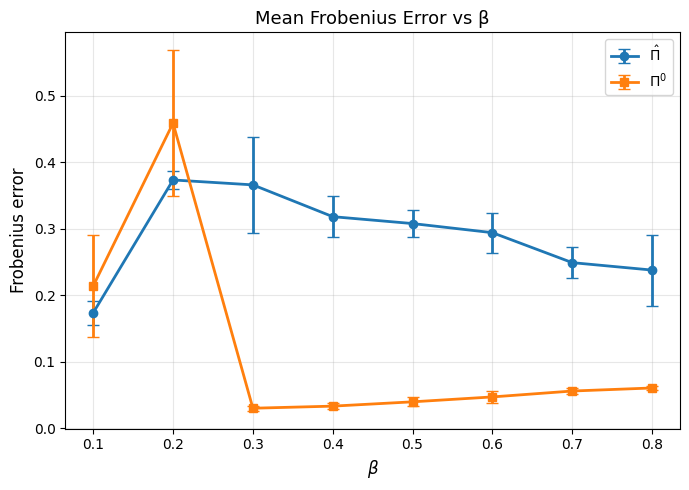

,Beta,DLPBM (mean ± std),KMeans (mean ± std)
0,0.1,0.173 ± 0.018,0.214 ± 0.076
1,0.2,0.373 ± 0.014,0.459 ± 0.109
2,0.3,0.366 ± 0.072,0.030 ± 0.004
3,0.4,0.318 ± 0.031,0.033 ± 0.004
4,0.5,0.308 ± 0.020,0.039 ± 0.007
5,0.6,0.294 ± 0.030,0.047 ± 0.009
6,0.7,0.249 ± 0.023,0.056 ± 0.004
7,0.8,0.238 ± 0.053,0.060 ± 0.003


In [18]:
graph_type = "hub"
hub_frob_norm = comparison_frob_norm(graph_type, beta_list, seed_list)


table_hub = plot_forb_beta_evolution(hub_frob_norm)
table_hub

# Disassortative


Total experiments:   0%|          | 0/32 [00:00<?, ?it/s]

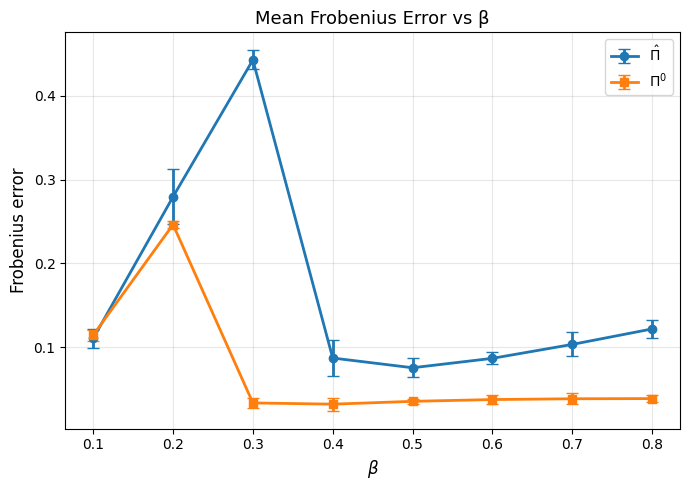

,Beta,DLPBM (mean ± std),KMeans (mean ± std)
0,0.1,0.111 ± 0.012,0.114 ± 0.007
1,0.2,0.279 ± 0.033,0.246 ± 0.004
2,0.3,0.443 ± 0.011,0.034 ± 0.006
3,0.4,0.087 ± 0.022,0.032 ± 0.008
4,0.5,0.075 ± 0.012,0.035 ± 0.003
5,0.6,0.087 ± 0.007,0.038 ± 0.006
6,0.7,0.103 ± 0.014,0.038 ± 0.007
7,0.8,0.122 ± 0.011,0.039 ± 0.004


In [19]:
graph_type = "disassortative"
disassortative_frob_norm = comparison_frob_norm(graph_type, beta_list, seed_list)

table_disassortative = plot_forb_beta_evolution(disassortative_frob_norm)
table_disassortative

# Assortative

Total experiments:   0%|          | 0/32 [00:00<?, ?it/s]

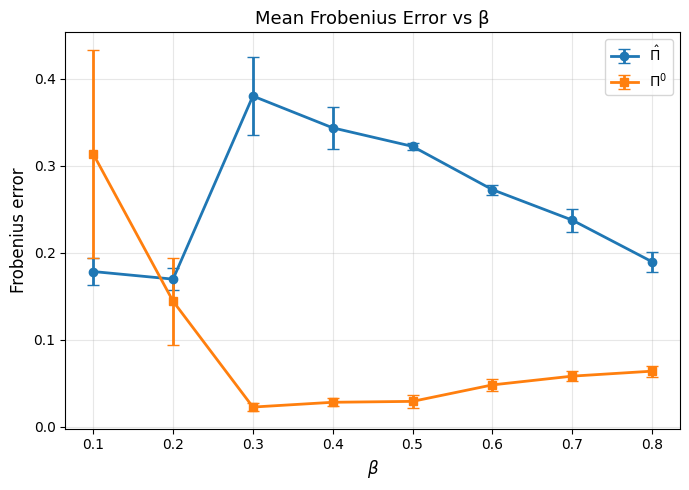

,Beta,DLPBM (mean ± std),KMeans (mean ± std)
0,0.1,0.178 ± 0.016,0.313 ± 0.119
1,0.2,0.170 ± 0.012,0.144 ± 0.050
2,0.3,0.380 ± 0.045,0.023 ± 0.004
3,0.4,0.343 ± 0.024,0.028 ± 0.004
4,0.5,0.322 ± 0.004,0.029 ± 0.008
5,0.6,0.272 ± 0.006,0.048 ± 0.007
6,0.7,0.237 ± 0.013,0.058 ± 0.006
7,0.8,0.189 ± 0.011,0.064 ± 0.006


In [20]:

graph_type = "assortative"
assortative_frob_norm = comparison_frob_norm(graph_type, beta_list, seed_list)

table_assortative = plot_forb_beta_evolution(assortative_frob_norm)
table_assortative

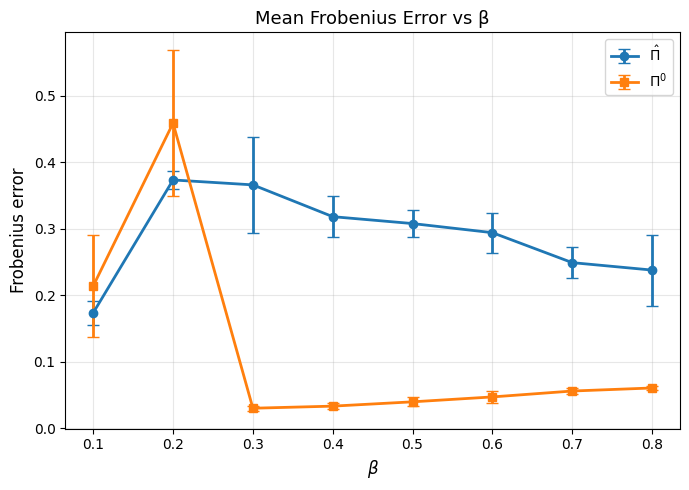

In [21]:
table_hub = plot_forb_beta_evolution(hub_frob_norm)
